# Introducing the `PFBPassband.jl` package

A [companion notebook](01_pfb_response.ipynb) describes how to calculate both
the unaliased and aliased frequeuncy response of a *polyphase filter bank*
(PFB).  In this notebook we will explore `PFBPassband.jl`, which provides a high
level interface for calculating the aliased PFB frequency response.  The aliased
PFB frequency response is often referred to a the *PFB passband*, hence the
package name.  As mentioned in the package's [`README.md`](../README.md) file,
which this notebook largely follows, the unaliased frequency response of a PFB
can be obtained by using the [`DSP.jl`](https://docs.juliadsp.org/latest/)
pacakge with the PFB coefficients obtained from `PFBPassband.jl`.  In this
notebook, "frequency response" will generally refer to the unaliased frequency
response while "passband" will generally to refer to the aliased frequency
response.

We will also look at PFB passbands of real world PFBs from the [Green Bank
Telescope](https://en.wikipedia.org/wiki/Green_Bank_Telescope) and the [MeerKAT
Radio Telescope](https://en.wikipedia.org/wiki/MeerKAT).

This notebook is a tutorial in how to use the `PFBPassband` package.  It is not
a comprehensive survey of the parameter space of PFB design, though it could
perhaps serve as a template for such an endeavour.

## Notebook setup

To ensure that all the requisite packages are avaiable for this noteboodk, we
need to setup its Julia environment.  The code in the following cell handles
that.  This will take some time (and produce more output) the first time you run
it, but subsequent runs will be faster (and produce less output).

In [1]:
import Pkg
Pkg.activate(@__DIR__)
if Pkg.is_manifest_current() != true
    Pkg.develop(path="..") # Needed until package is registered in General
    Pkg.precompile();
end

  Activating project at `~/.julia/dev/PFBPassband/notebooks`


## PFB specifications

### Low level PFB specification

The (unaliased) response of the PFB filter coefficients at a given frequency can
be computed from the coefficients alone (and the given frequency).  To compute
the (aliased) passband of a PFB channel at a given frequency within the channel
we also need to know the number of channels of the PFB so we will know how the
post-decimation power will alias into the PFB channel.  The `PFBPassband.jl`
package provides the `passband(h, nchan, nfine)` which will compute the
(aliases) passband response for `nfine` evenly spaced points across a PFB
channel for the given `nchan` channel PFB with coefficients, `h`.  Here again
the `nchan` value includes both positive and negative frequencies.  This method
computes the PFB channel passband for any PFB whose coefficients are and number
of channels are known.

### High level PFB specification

While specifying a PFB by its filter coefficiients and number of channels is
extremely generalized, it is also possible to specify a PFB by a small number of
parameters and an implicit parameterized implementation.  One example of this,
and the primary/initial focus of the `PFBPassband.jl` package, is the PFB
implementation of the CASPER tool flow.

The CASPER PFB is parameterized by several parameters, including one that
indicates whether to model a known buggy version of the CASPER PFB.
The `PFBPassband.jl` package provides the `CasperPolyphaseFilterbank` structure
that encapsulates these parameters.  As specified in the `README.md` file, these
parameters are:

- Number of channels (`nchan`)
- Number of taps (`ntaps`)
- Normalized channel width (`width`)
- Windowing function (`window`)
- Low pass filter function (`lpf`)
- Bug flag (whether to model bug) (`bug`)

Please refer the `README.md` file and/or the doc string of the
`CasperPolyphaseFilterbank` structure for more information.  The
`PFBPassband.jl` package provides several constructors for thie structure, but
for maximum clarity we will use the one that takes only keywaord arguments.

Other PFB implementations can be added in future versions of `PFBPassband.jl`.

## PFB frequency response (unaliased)

The (unaliased) frequency response of a PFB can be computed by using the
`DSP.jl` pacakge.  This requires obtaining the PFB filter coefficients.  Because
there is no aliasing, the number of PFB channels is not important for the
response itself, but it can be useful to know when interpreting/plotting the
response.

Let's compare the (unaliased) freqeuncy response of two CASPER PFBs that share
common design parameters except for the `width` parameter.  One will have
`width=1` and the other will have `width=7/8`.  We will plot the frequency
response for three adjacent PFB channels using 256 points per coarse channel.

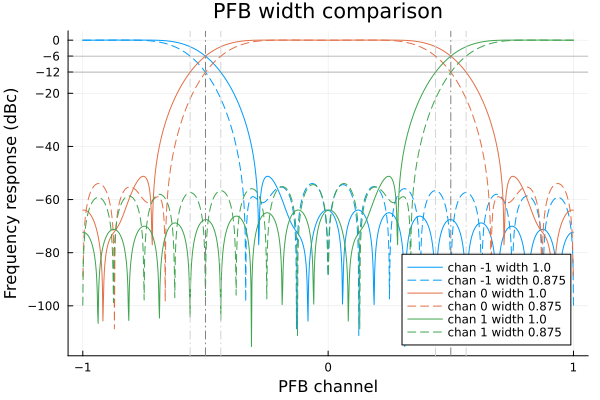

In [2]:
using PFBPassband, DSP, Plots

# Specify common PFB parameters
nchan = 16
ntaps = 8

# Create PFBs
pfb1 = CasperPolyphaseFilterbank(nchan, ntaps; width=1.0)
pfb2 = CasperPolyphaseFilterbank(nchan, ntaps; width=7/8)

# Generate w values at which to plot central channel and adjacent channels
nfine = 256
w = range(-2/nchan, step=1/(nchan*nfine), stop=+2/nchan) .* π;

# For these small/few PFBs, calling coefs repeatedly isn't a big deal,
# but for larger/more PFBs caching the results can be beneficial.
coefcache = Dict{CasperPolyphaseFilterbank,Vector{Float64}}()

# For each PFB, plot the frequency response for each of the three channels
p = plot(
    title="PFB width comparison",
    xlabel="PFB channel", xticks=-1:1,
    ylabel="Frequency response (dBc)", yticks=vcat(-120:20:-20,-12,-6,0)
)

for c in -1:1
    for (pfb, ls) in (pfb1=>:solid, pfb2=>:dash)
        # Get coefs from cache (and add as needed)
        h = get!(()->coefs(pfb), coefcache, pfb)
        hc = h .* cispi.(2*c.*(0:nchan*ntaps-1)/nchan)
        H = freqresp(PolynomialRatio(hc, [1]), w);
        plot!(p, w*nchan/2π, 10log10.(abs2.(H)); ls, color=c+2, label="chan $c width $(pfb.width)")
    end
end

vline!(p, [-0.5, 0.5], lc=:gray, ls=:dashdot, primary=false)
vline!(p, [-0.5-1/16, -0.5+1/16, 0.5-1/16, 0.5+1/16], lc=:lightgray, ls=:dashdot, primary=false)
hline!(p, [-12, -6], lc=:gray, lw=0.5, primary=false)

## PFB frequency response (aliased)

The PFB passband (i.e. the aliased frequency response of each PFB channel) can
be computed by using the `passband` function of the `PFBPassband` package.
Let's compare the PFB passband of the two PFBs we created above.  Because most
of the aliased power at the channel edge comes from the adjacent channel, the
(aliased) passband at the channel edges is approximately 3 dB above the
(unaliased) frequency response at the channel edges.  Eagle eyed readers will
notice that the final fine channel plotted is not quite at 0.5.  The fine
channel that would be at 0.5 is actually the fine channel at -0.5 of the
adjacent PFB channel.  The plot could be made more symmetric by duplicating the
-0.5 point at +0.5, but then we get to talk about this little quirk (and with
256 points across the channel it is not visually significant).

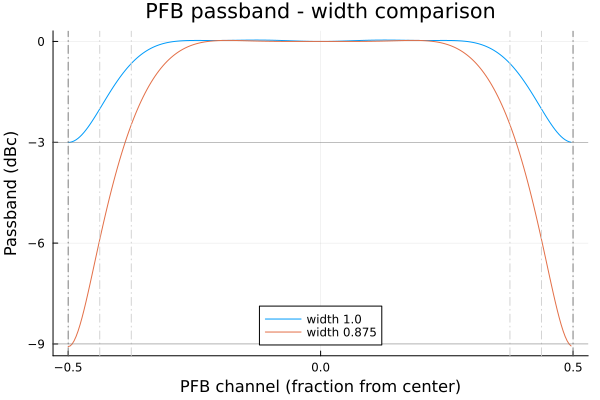

In [3]:
# For each PFB, plot the frequency response for each of the three channels
p = plot(
    title="PFB passband - width comparison",
    xlabel="PFB channel (fraction from center)", xticks=-0.5:0.5:0.5,
    ylabel="Passband (dBc)", yticks=-9:3:0,
    legend=:bottom
)

# Define x axis values (fraction of PFB channel from center)
xx = range(-0.5, step=1/nfine, length=nfine)

for pfb in (pfb1, pfb2)
    pb = passband(pfb, nfine)
    plot!(p, xx, 10log10.(pb); label="width $(pfb.width)")
end

vline!(p, [-0.5, 0.5], lc=:gray, ls=:dashdot, primary=false)
vline!(p, [-0.5+1/16, -0.5+2/16, 0.5-2/16, 0.5-1/16], lc=:lightgray, ls=:dashdot, primary=false)
hline!(p, [-9, -3], lc=:gray, lw=0.5, primary=false)
display(p)

#### Analyzing arbitrary (i.e. non-CASPER) PFBs

Notice that we called `passband(pfb, nfine)` to get the passband response for
`nfine` equally spaced points across the coarse channel, where `pfb` is a
`CasperPolyphaseFilterbank`.  The `passband` function can also be used to
compute the passband of an arbitrary PFB given its coefficients, its `nchan`
parameter, and `nfine`.  In fact, `passband(pfb, nfine)` is exactly equivalent
to `passband(coefs(pfb), pfb.nchan, nfine)`.

## Real world PFBs

Now we get to look at some real world PFBs.  The PFBs shown below are in use at
ome of the world's preeminent radio telescopes: the Green Bank Telescope,
the MeerKAT Radio Telescope, the Very Large Array (VLA), and the Allen Telescope
Array (ATA).  If you would like to add a PFB for your favorite radio telescope
(or other application), please submit a pull request.

### Green Bank Telescope

The Versatile Green Bank Astronomical Spectrometer (VEGAS) backend of the Green
Bank Telescope (GBT) has many different modes of operation.  Some of the modes
use a direct digital downconverter and some of them use a PFB.  We are going to
focus on the GBT PFB used by the Breakthrough Listen project.  It is a CASPER
PFB with the following parameters:

| nchan | ntaps | width | window  | lpf  | bug  |
|------:|------:|------:|:-------:|:----:|:----:|
|  1024 |    12 |   1.0 | hamming | sinc | true |

Remember that `nchan` includes both positive and negative frequencies.  This PFB
has real inputs, so only the non-redundant half of the channels are output.
Here is its passband:

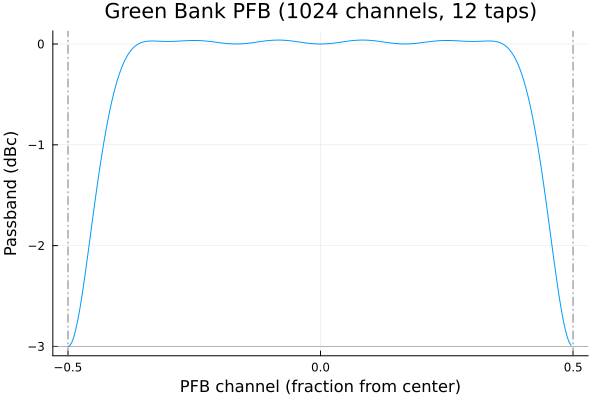

In [4]:
gbtpfb = CasperPolyphaseFilterbank(nchan=1024, ntaps=12, bug=true)
gbtpb = passband(gbtpfb, nfine)
plot(xx, 10log10.(gbtpb), legend=false,
    title="Green Bank PFB (1024 channels, 12 taps)",
    xlabel="PFB channel (fraction from center)", xticks=[-0.5,0,0.5],
    ylabel="Passband (dBc)"
)
vline!([-0.5, 0.5], lc=:gray, ls=:dashdot, primary=false)
hline!([-3], lc=:gray, lw=0.5, primary=false)

### MeerKAT Radio Telescope

The MeerKAT Radio Telescope provides three main modes of channelization:

-  1K mode (1024 non-redundant channels, `nchan=2048`)
-  4K mode (4096 non-redundant channels, `nchan=8192`)
-  32K mode (32768 non-redundant channels, `nchan=65536`)

These are all CASPER PFBs with the following parameters:

| mode | nchan | ntaps | width | window  | lpf  |  bug  |
|-----:|------:|------:|------:|:-------:|:----:|:-----:|
|   1K |  2047 |    16 |  0.91 | hanning | sinc | false |
|   4K |  8192 |    16 |  1.00 | hanning | sinc | false |
|  32K | 65536 |     4 |  1.00 | hanning | sinc | false |

Remember that `nchan` includes both positive and negative frequencies.  These
PFBs have real inputs, so only the non-redundant half of the channels are
output.  Here are their passbands:

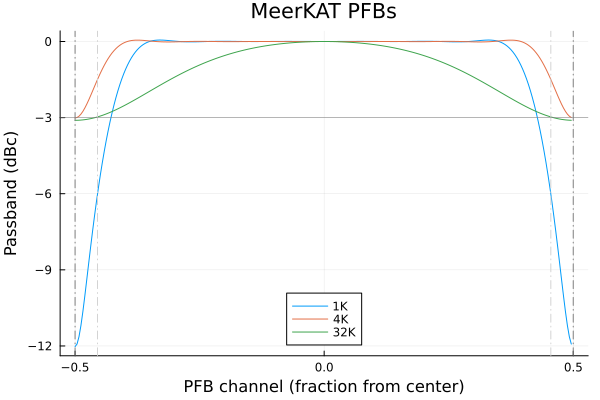

In [5]:
# pfbsmk is a tuple of pairs
pfbsmk = (
    "1K"=>CasperPolyphaseFilterbank(nchan=2048, ntaps=16, width=0.91, window=hanning),
    "4K"=>CasperPolyphaseFilterbank(nchan=8192, ntaps=16, width=1, window=hanning),
    "32K"=>CasperPolyphaseFilterbank(nchan=2048, ntaps=4, width=1, window=hanning)
)

gbtpb = passband(gbtpfb, nfine)
p = plot(legend=:bottom,
    title="MeerKAT PFBs",
    xlabel="PFB channel (fraction from center)", xticks=[-0.5,0,0.5],
    ylabel="Passband (dBc)", yticks=-12:3:0
)
for (label, pfb) in pfbsmk
    pb = passband(pfb, nfine)
    plot!(p, xx, 10log10.(pb); label)
end
vline!(p, [-0.5, 0.5], lc=:gray, ls=:dashdot, primary=false)
vline!(p, [-0.91/2, +0.91/2], lc=:lightgray, ls=:dashdot, primary=false)
hline!(p, [-3], lc=:gray, lw=0.5, primary=false)

### Very Large Array/COSMIC and Allen Telescope Array

The Very Large Array's commensal backend COSMIC and the Allen Telescope Array
both use a CASPER PFB with the parameters as shown here:

| nchan | ntaps | width | window  | lpf  | bug  |
|------:|------:|------:|:-------:|:----:|:----:|
|  2048 |     4 |   1.0 | hamming | sinc | true |

Remember that `nchan` includes both positive and negative frequencies.  This PFB
has real inputs, so only the non-redundant half of the channels are output.
Here is its passband:

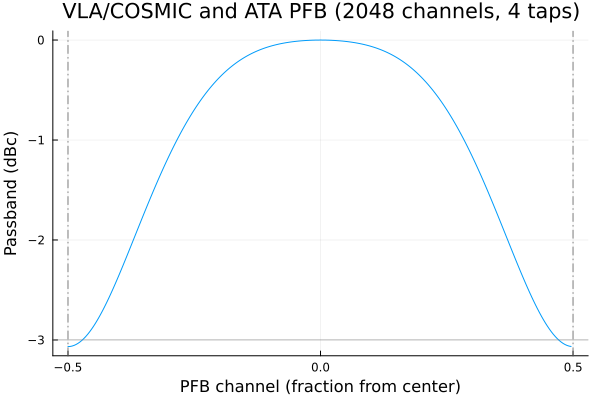

In [6]:
vlaatapfb = CasperPolyphaseFilterbank(nchan=2048, ntaps=4, bug=true)
vlaatapb = passband(vlaatapfb, nfine)
plot(xx, 10log10.(vlaatapb), legend=false,
    title="VLA/COSMIC and ATA PFB (2048 channels, 4 taps)",
    xlabel="PFB channel (fraction from center)", xticks=[-0.5,0,0.5],
    ylabel="Passband (dBc)"
)
vline!([-0.5, 0.5], lc=:gray, ls=:dashdot, primary=false)
hline!([-3], lc=:gray, lw=0.5, primary=false)

## Review

This notebook showed:

1. How to use `PFBPassband.jl` to model CASPER polyphase fitlerbanks
1. How to generate the PFB filter coefficients for a CASPER polyphase filterbank
1. How to use `DSP.jl` to compute the (unaliased) freqeuncy response of PFB
   filter coefficients
1. How to use the `passband` function to compute the (aliased) PFB passband
1. The PFB passband shape of PFBs in active use at several different radio
   telescopes

You are now ready to start your own study of PFB design parameters.  Have fun!